# Final Version
 ### Nati Marcus and James Dugle

For this project, we are seeking to analyze the sentiment of articles from the New York Times regarding former presidential candidates, Hillary Clinton and Donald Trump. We are also going to examine polling data for these candidates to see if the scores are correlated with the polling data.

In [197]:
#importing all packages used
import requests
from bs4 import BeautifulSoup
import datetime
import numpy as np
import pandas as pd
import pollster
from textblob import TextBlob
import re
import pickle
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/natimarcus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Preprocessing

In [88]:
#creating json with all nyt articles from june to november
months = [6,7,8,9,10,11]
key = 'KEY'
json_months = []
for i in months:
    url = 'https://api.nytimes.com/svc/archive/v1/2016/{}.json?api-key={}'.format(i,key)
    res = requests.get(url)
    json = res.json()
    docs = json['response']['docs']
    json_months.append(docs)

In [89]:
#getting html article links and other metadata for articles about trump and clinton
#in presidential election
html_articles = []

def filter(json_months):
    def parseForCandidates(keyword):
        nonlocal metadata

        if keyword['name'] == 'persons' and keyword['value'] == 'Trump, Donald J':
            metadata['trump'] = keyword['rank']
        if keyword['name'] == 'persons' and keyword['value'] == 'Clinton, Hillary Rodham':
            metadata['clinton'] = keyword['rank']
            
    metadata = {'clinton': -1, 'trump': -1}
    
    for month in json_months:
        for media in month:
            if media['document_type'] == 'article' and media['web_url'][-4:] == 'html' and media['section_name'] == 'U.S.':
                shouldAdd = False
                metadata = {'clinton': -1, 'trump': -1}
                for item in media['keywords']:
                    parseForCandidates(item)
                    if item['value'] == 'Presidential Election of 2016':
                        sep = media['pub_date'].split('T')
                        date = sep[0]
                        dateFinal = datetime.datetime.strptime(date, '%Y-%m-%d')
#                         print('add')
                        shouldAdd = True
                if shouldAdd:
                    html_articles.append([media['web_url'],media['type_of_material'],dateFinal, metadata['clinton'], metadata['trump']])

filter(json_months)                    
len(html_articles)

1597

In [221]:
#only containing dates from when each candidate was nominated
finalHTML = []
for i in html_articles:
    if i[2] >= datetime.datetime(2016,6,14,0,0) and i[2] <= datetime.datetime(2016,11,8,0,0):
        finalHTML.append(i) 
len(finalHTML)

1351

In [222]:
#creating df of metadata
dataframe = pd.DataFrame(np.asarray(finalHTML), columns = ['url','article_type', 'date', 'clinton_rank', 'trump_rank'])
dataframe.head()

,url,article_type,date,clinton_rank,trump_rank
0,https://www.nytimes.com/2016/06/14/us/politics...,News,2016-06-14,9,10
1,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,9
2,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,-1
3,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,4
4,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,-1


In [223]:
dataframe.shape

(1351, 5)

In [224]:
#excluding articles not containing trump or clinton in metadata
df = dataframe[((dataframe['clinton_rank']!=-1) & (dataframe['trump_rank'] != -1)) | ((dataframe['clinton_rank']!=-1) | (dataframe['trump_rank'] != -1))]
df.head()

,url,article_type,date,clinton_rank,trump_rank
0,https://www.nytimes.com/2016/06/14/us/politics...,News,2016-06-14,9,10
1,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,9
3,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,4
5,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,5
6,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,7,1


In [225]:
df.shape

(1105, 5)

In [226]:
#creating column with article title
def get_title(url):
    title = url[47:]
    return title
df['article_title'] = df['url'].apply(get_title)
df.head()

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,url,article_type,date,clinton_rank,trump_rank,article_title
0,https://www.nytimes.com/2016/06/14/us/politics...,News,2016-06-14,9,10,shooting-reaction.html
1,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,9,bernie-sanders-campaign.html
3,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,4,third-party-candidate.html
5,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,5,russian-hackers-dnc-trump.html
6,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,7,1,donald-trump-shooting-response.html


In [227]:
df.shape

(1105, 6)

## Sentiment Analysis

In [228]:
#creating pickle file with sentiment scores of articles
filename = 'TextBlobAndVader.pkl'
sid = SentimentIntensityAnalyzer()

scores = {}
for url in df['url']:
    try:
        res = requests.get(url)
    except requests.ConnectionError:
        pass
    if str(res) == '<Response [200]>': 
        html = res.text
        doc = BeautifulSoup(html, 'html.parser')
        try:
            text = doc.find_all('div',attrs = {'class':'css-53u6y8'})
            List = [i.text for i in text]
            joined = ' '.join(List)
            TB = TextBlob(joined)
            vader_scores = sid.polarity_scores(joined)
            sentiment = [TB.sentiment[0],TB.sentiment[1], vader_scores['compound']]
            scores.update({url:sentiment})
        except: 
            pass
    

with open(filename, 'wb') as f:
    pickle.dump(scores, f)

In [229]:
#opening file
with open(filename, 'rb') as f:
    mynewdict = pickle.load(f)
mynewdict

{'https://www.nytimes.com/2016/06/14/us/politics/shooting-reaction.html': [0.14386032037547192,
  0.46526578920518313,
  -0.9992],
 'https://www.nytimes.com/2016/06/15/us/politics/bernie-sanders-campaign.html': [0.15433817093653157,
  0.4427075201665365,
  0.9958],
 'https://www.nytimes.com/2016/06/15/us/politics/third-party-candidate.html': [-0.013746487430697956,
  0.43283682691577424,
  0.7299],
 'https://www.nytimes.com/2016/06/15/us/politics/russian-hackers-dnc-trump.html': [0.014277882205513789,
  0.344439223057644,
  0.9422],
 'https://www.nytimes.com/2016/06/15/us/politics/donald-trump-shooting-response.html': [0.04769640439743532,
  0.4128369482750927,
  -0.9914],
 'https://www.nytimes.com/2016/06/15/us/politics/trump-immigration-rally-lgbt.html': [0.16036939475618725,
  0.4191958670260557,
  0.3393],
 'https://www.nytimes.com/2016/06/16/us/politics/donald-trump-gun-control-nra.html': [0.06909290271132376,
  0.4447875370243791,
  -0.9935],
 'https://www.nytimes.com/2016/06/16/

In [230]:
len(mynewdict)

1105

In [231]:
#creating column with sentiment and subjectivity scores
df['sent_list'] = df['url'].map(mynewdict)
df.head()

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,url,article_type,date,clinton_rank,trump_rank,article_title,sent_list
0,https://www.nytimes.com/2016/06/14/us/politics...,News,2016-06-14,9,10,shooting-reaction.html,"[0.14386032037547192, 0.46526578920518313, -0...."
1,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,9,bernie-sanders-campaign.html,"[0.15433817093653157, 0.4427075201665365, 0.9958]"
3,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,4,third-party-candidate.html,"[-0.013746487430697956, 0.43283682691577424, 0..."
5,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,5,russian-hackers-dnc-trump.html,"[0.014277882205513789, 0.344439223057644, 0.9422]"
6,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,7,1,donald-trump-shooting-response.html,"[0.04769640439743532, 0.4128369482750927, -0.9..."


In [232]:
df.shape

(1105, 7)

In [236]:
#spliting column into three columns: tb score, tb subjectivity, and vader score
scores = df.sent_list.apply(pd.Series)
scores.rename(columns={0:'tb_sentiment',1:'tb_subjectivity',2:'vader_sentiment'},inplace=True)
df = pd.concat([df, scores], axis = 1)
df.drop(columns=['sent_list'],inplace=True)
df.head()

,url,article_type,date,clinton_rank,trump_rank,article_title,tb_sentiment,tb_subjectivity,vader_sentiment
0,https://www.nytimes.com/2016/06/14/us/politics...,News,2016-06-14,9,10,shooting-reaction.html,0.143860,0.465266,-0.9992
1,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,9,bernie-sanders-campaign.html,0.154338,0.442708,0.9958
3,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,5,4,third-party-candidate.html,-0.013746,0.432837,0.7299
5,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,5,russian-hackers-dnc-trump.html,0.014278,0.344439,0.9422
6,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,7,1,donald-trump-shooting-response.html,0.047696,0.412837,-0.9914


In [237]:
#making date column datetime
df['date']= pd.to_datetime(df['date'])

In [238]:
df.shape

(1105, 9)

In [239]:
#making column that distinguishes trump article from clinton article
name = {}
for index, row in df.iterrows():
    if row['clinton_rank'] < 0 or row['trump_rank'] < 0:
        if row['clinton_rank'] == -1 and 'trump' in row['article_title']:
            name.update({row['url']:'Trump'})
        if row['trump_rank'] == -1 and 'clinton' in row['article_title']:
            name.update({row['url']:'Clinton'})
    elif row['clinton_rank'] > 0 and row['trump_rank'] > 0: 
        if row['clinton_rank']<row['trump_rank'] and 'clinton' in row['article_title'] and 'trump' not in row['article_title']:
            name.update({row['url']:'Clinton'}) 
        elif row['trump_rank']<row['clinton_rank'] and 'trump' in row['article_title'] and 'clinton' not in row['article_title']:
            name.update({row['url']:'Trump'})
        elif 'clinton' in row['article_title'] and 'trump' in row['article_title']:
            name.update({row['url']:'Both'})
        else:
            name.update({row['url']:'Other'})
df['candidate'] = df['url'].map(name)
df = df[(df['candidate'] == 'Trump') | (df['candidate'] == 'Clinton')]
df.head()

,url,article_type,date,clinton_rank,trump_rank,article_title,tb_sentiment,tb_subjectivity,vader_sentiment,candidate
5,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,5,russian-hackers-dnc-trump.html,0.014278,0.344439,0.9422,Trump
6,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,7,1,donald-trump-shooting-response.html,0.047696,0.412837,-0.9914,Trump
8,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-15,-1,2,trump-immigration-rally-lgbt.html,0.160369,0.419196,0.3393,Trump
10,https://www.nytimes.com/2016/06/16/us/politics...,News,2016-06-15,-1,3,donald-trump-gun-control-nra.html,0.069093,0.444788,-0.9935,Trump
13,https://www.nytimes.com/2016/06/16/us/politics...,News,2016-06-15,-1,3,on-donald-trump-republicans-keep-distance-in-d...,0.100773,0.448005,0.9905,Trump


In [240]:
df.shape

(664, 10)

In [242]:
#making dictionaries containing daily average tb sentiment scores for each candidate
import numpy as np
import collections
date_sent_total = collections.defaultdict(int)
date_counts = collections.defaultdict(int)

candidates = ['Trump','Clinton']
trump = []
clinton = []
for candidate in candidates:
    for index, row in df.iterrows():
        if row['candidate'] == candidate:
            date = row['date']
            score = row['tb_sentiment']

            date_sent_total[date] += score
            date_counts[date] += 1

            date_avgs = {}
            for date in date_sent_total:
                date_avgs[date] = np.round(date_sent_total[date]/date_counts[date],4)
    if candidate == 'Trump':
        trump.append(date_avgs)
        date_avgs = {}
    clinton.append(date_avgs)

In [243]:
clinton = clinton[1]

In [244]:
trump = trump[0]

In [245]:
#adding column for daily average tb sentiment scores
df['tb_daily_avg'] = np.where(df['candidate'] == 'Trump', df['date'].map(trump), df['date'].map(clinton))

In [246]:
df.head()

,url,article_type,date,clinton_rank,trump_rank,article_title,tb_sentiment,tb_subjectivity,vader_sentiment,candidate,tb_daily_avg
5,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,5,russian-hackers-dnc-trump.html,0.014278,0.344439,0.9422,Trump,0.0310
6,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,7,1,donald-trump-shooting-response.html,0.047696,0.412837,-0.9914,Trump,0.0310
8,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-15,-1,2,trump-immigration-rally-lgbt.html,0.160369,0.419196,0.3393,Trump,0.1101
10,https://www.nytimes.com/2016/06/16/us/politics...,News,2016-06-15,-1,3,donald-trump-gun-control-nra.html,0.069093,0.444788,-0.9935,Trump,0.1101
13,https://www.nytimes.com/2016/06/16/us/politics...,News,2016-06-15,-1,3,on-donald-trump-republicans-keep-distance-in-d...,0.100773,0.448005,0.9905,Trump,0.1101


In [247]:
#making dictionaries containing daily average vader sentiment scores for each candidate
date_sent_total = collections.defaultdict(int)
date_counts = collections.defaultdict(int)

candidates = ['Trump','Clinton']
trump = []
clinton = []
for candidate in candidates:
    for index, row in df.iterrows():
        if row['candidate'] == candidate:
            date = row['date']
            score = row['vader_sentiment']

            date_sent_total[date] += score
            date_counts[date] += 1

            date_avgs = {}
            for date in date_sent_total:
                date_avgs[date] = np.round(date_sent_total[date]/date_counts[date],4)
    if candidate == 'Trump':
        trump.append(date_avgs)
        date_avgs = {}
    clinton.append(date_avgs)
clinton = clinton[1]
trump = trump[0]
#adding column for daily average vader sentiment scores
df['vader_daily_avg'] = np.where(df['candidate'] == 'Trump', df['date'].map(trump), df['date'].map(clinton))

In [248]:
df.head()

,url,article_type,date,clinton_rank,trump_rank,article_title,tb_sentiment,tb_subjectivity,vader_sentiment,candidate,tb_daily_avg,vader_daily_avg
5,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,-1,5,russian-hackers-dnc-trump.html,0.014278,0.344439,0.9422,Trump,0.0310,-0.0246
6,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-14,7,1,donald-trump-shooting-response.html,0.047696,0.412837,-0.9914,Trump,0.0310,-0.0246
8,https://www.nytimes.com/2016/06/15/us/politics...,News,2016-06-15,-1,2,trump-immigration-rally-lgbt.html,0.160369,0.419196,0.3393,Trump,0.1101,0.1121
10,https://www.nytimes.com/2016/06/16/us/politics...,News,2016-06-15,-1,3,donald-trump-gun-control-nra.html,0.069093,0.444788,-0.9935,Trump,0.1101,0.1121
13,https://www.nytimes.com/2016/06/16/us/politics...,News,2016-06-15,-1,3,on-donald-trump-republicans-keep-distance-in-d...,0.100773,0.448005,0.9905,Trump,0.1101,0.1121


## Graph of Sentiment Scores Over Time

### TextBlob

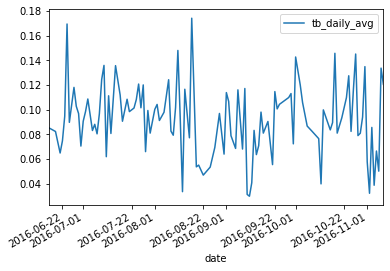

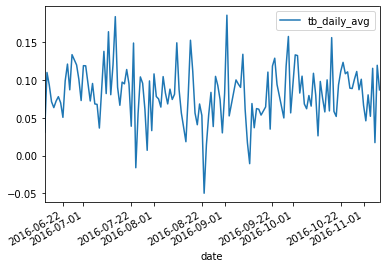

In [249]:
#plotting tb sentiment per candidate
import matplotlib.pyplot as plt
df.sort_values('date').groupby('candidate').plot(x='date',y='tb_daily_avg');

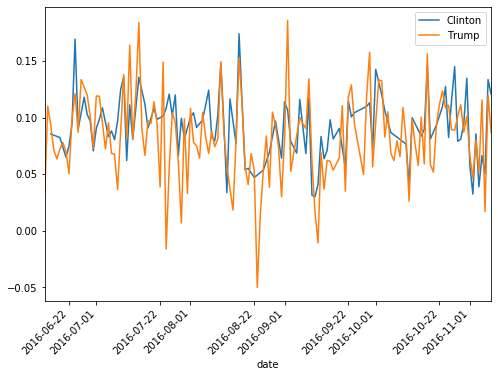

In [250]:
#combining plots
fig, ax = plt.subplots(figsize=(8,6))
for label, sub_df in df.groupby('candidate'):
    sub_df.plot(ax=ax, label=label, x='date', y = 'tb_daily_avg')
    plt.xticks(rotation = 45)
plt.legend();

In [251]:
#summary stats for average tb sentiment scores by candidate
df['tb_daily_avg'].groupby(df['candidate']).describe()

,count,mean,std,min,25%,50%,75%,max
candidate,,,,,,,,
Clinton,236.0,0.093719,0.027542,0.03,0.0791,0.0968,0.1113,0.1741
Trump,428.0,0.082623,0.032567,-0.05,0.0622,0.0821,0.1003,0.1860


### VADER

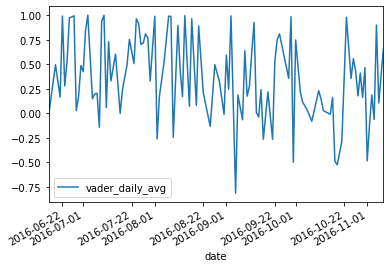

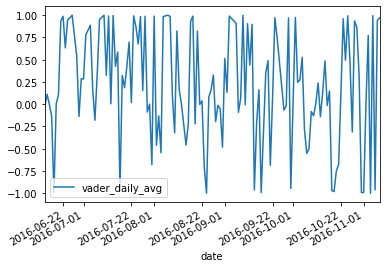

In [252]:
#plotting vader sentiment per candidate
import matplotlib.pyplot as plt
df.sort_values('date').groupby('candidate').plot(x='date',y='vader_daily_avg');

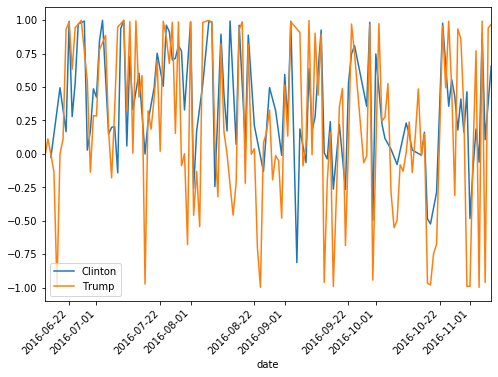

In [253]:
#combining plots
fig, ax = plt.subplots(figsize=(8,6))
for label, sub_df in df.groupby('candidate'):
    sub_df.plot(ax=ax, label=label, x='date', y = 'vader_daily_avg')
    plt.xticks(rotation = 45)
plt.legend();

In [254]:
#summary stats for average vader sentiment scores by candidate
df['vader_daily_avg'].groupby(df['candidate']).describe()

,count,mean,std,min,25%,50%,75%,max
candidate,,,,,,,,
Clinton,236.0,0.390648,0.387408,-0.8136,0.1612,0.35565,0.7301,0.9990
Trump,428.0,0.203697,0.539915,-0.9987,-0.1320,0.15910,0.6964,0.9985


## Polling Data

In [35]:
#making list of polling avgs for each candidate
import json
with open('2016-general-election-trump-vs-clinton-vs-johnson.json') as f:
    data = json.load(f)

results = []
for estimate in data['estimates_by_date']:
    date = estimate['date']
    result = (date, estimate['estimates'][0]['value'], estimate['estimates'][1]['value'])
    results.append(result)

In [36]:
#creating dataframe for polling data
results_df = pd.DataFrame(results, columns = ['date', 'trump_avg', 'clinton_avg']).sort_values(by='date')

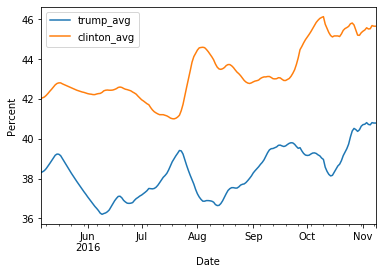

In [165]:
#plotting polling data for both candidates
results_df.plot(x = 'date')
#plt.xticks(rotation=45)
plt.ylabel('Percent');
plt.xlabel('Date');

## Creating Dataframe with Polling Data and Sentiment Scores per Day

In [45]:
results_df.head()

,date,trump_avg,clinton_avg
186,2016-05-06,38.30,42.03
185,2016-05-07,38.34,42.06
184,2016-05-08,38.40,42.10
183,2016-05-09,38.50,42.18
182,2016-05-10,38.63,42.28


In [47]:
results_df['date'] = pd.to_datetime(results_df['date'])

In [48]:
#making smaller polling df with only dates included in sentiment analysis
new_df = results_df[(results_df['date'] >= datetime.datetime(2016,6,14,0,0)) & (results_df['date'] <= datetime.datetime(2016,11,8,0,0)) ] 

In [49]:
new_df.shape

(148, 3)

In [255]:
#creating list of daily avg sentiment scores for tb and vader, with each candidate an date included
sents = []
for index, row in df.iterrows():
    entry = [row['date'],row['candidate'],row['tb_daily_avg'],row['vader_daily_avg']]
    if entry not in sents:
        sents.append(entry)
len(sents)

248

In [256]:
#creating df of daily avg sentiment scores
sent_df = pd.DataFrame(sents, columns = ['date', 'candidate', 'tb_daily_avg','vader_daily_avg']).sort_values(by='date')

In [257]:
sent_df.head()

,date,candidate,tb_daily_avg,vader_daily_avg
0,2016-06-14,Trump,0.0310,-0.0246
1,2016-06-15,Trump,0.1101,0.1121
2,2016-06-16,Clinton,0.0855,-0.0251
3,2016-06-16,Trump,0.0935,-0.0032
4,2016-06-17,Trump,0.0713,-0.1347


In [258]:
#making df for trump sentiment scores with each date as row
trump_df = sent_df[sent_df['candidate'] == 'Trump']
trump_df.rename(columns={'tb_daily_avg':'tb_trump_daily_avg','vader_daily_avg':'vader_trump_daily_avg'},inplace=True)
trump_df.drop(columns=['candidate'],inplace=True)
trump_df.head()

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,tb_trump_daily_avg,vader_trump_daily_avg
0,2016-06-14,0.0310,-0.0246
1,2016-06-15,0.1101,0.1121
3,2016-06-16,0.0935,-0.0032
4,2016-06-17,0.0713,-0.1347
5,2016-06-18,0.0635,-0.9970


In [259]:
#making df for clinton sentiment scores with each date as row
clinton_df = sent_df[sent_df['candidate'] == 'Clinton']
clinton_df.rename(columns={'tb_daily_avg':'tb_clinton_daily_avg','vader_daily_avg':'vader_clinton_daily_avg'},inplace=True)
clinton_df.drop(columns=['candidate'],inplace=True)
clinton_df.head()

,date,tb_clinton_daily_avg,vader_clinton_daily_avg
2,2016-06-16,0.0855,-0.0251
7,2016-06-19,0.0824,0.4950
10,2016-06-21,0.0650,0.1655
11,2016-06-22,0.0748,0.9905
14,2016-06-23,0.0948,0.2789


In [260]:
#combining clinton and trump sentiment df
DF = pd.merge(trump_df, clinton_df, how='outer', on='date')

In [261]:
DF.head()

,date,tb_trump_daily_avg,vader_trump_daily_avg,tb_clinton_daily_avg,vader_clinton_daily_avg
0,2016-06-14,0.0310,-0.0246,NaN,NaN
1,2016-06-15,0.1101,0.1121,NaN,NaN
2,2016-06-16,0.0935,-0.0032,0.0855,-0.0251
3,2016-06-17,0.0713,-0.1347,NaN,NaN
4,2016-06-18,0.0635,-0.9970,NaN,NaN


In [262]:
DF.shape

(144, 5)

In [263]:
new_df.head()

,date,trump_avg,clinton_avg
147,2016-06-14,36.57,42.44
146,2016-06-15,36.73,42.45
145,2016-06-16,36.88,42.48
144,2016-06-17,37.00,42.52
143,2016-06-18,37.10,42.58


In [264]:
#making df with sentiment scores and polling for each candidate with each date as row
final = pd.merge(DF, new_df, how='outer', on='date')

In [265]:
#renaming columns
final.rename(columns={'date':'Date','tb_trump_daily_avg':'TrumpTB','tb_clinton_daily_avg':'ClintonTB',
                      'trump_avg':'TrumpPoll','clinton_avg':'ClintonPoll',
                      'vader_trump_daily_avg':'TrumpVADER','vader_clinton_daily_avg':'ClintonVADER'},inplace=True)
final.head()

,Date,TrumpTB,TrumpVADER,ClintonTB,ClintonVADER,TrumpPoll,ClintonPoll
0,2016-06-14,0.0310,-0.0246,NaN,NaN,36.57,42.44
1,2016-06-15,0.1101,0.1121,NaN,NaN,36.73,42.45
2,2016-06-16,0.0935,-0.0032,0.0855,-0.0251,36.88,42.48
3,2016-06-17,0.0713,-0.1347,NaN,NaN,37.00,42.52
4,2016-06-18,0.0635,-0.9970,NaN,NaN,37.10,42.58


## Regression Analysis

In [33]:
from sklearn.linear_model import LinearRegression

### TextBlob

Trump Scores:

In [266]:
#computing regression for trump tb scores
X = np.array(final['TrumpTB'][final['TrumpTB'].isna() == False]).reshape(-1,1)
y = final['TrumpPoll'][final['TrumpTB'].isna() == False]

reg = LinearRegression().fit(X,y)
print(reg.coef_,reg.score(X,y))

[0.70667471] 0.0004784220239147929


Clinton Scores:

In [267]:
#computing regression for clinton tb scores
X = np.array(final['ClintonTB'][final['ClintonTB'].isna() == False]).reshape(-1,1)
y = final['ClintonPoll'][final['ClintonTB'].isna() == False]

reg = LinearRegression().fit(X,y)
print(reg.coef_,reg.score(X,y))

[-2.24469825] 0.0018655675842539354


### VADER

Trump Scores:

In [268]:
#computing regression for trump vader scores
X = np.array(final['TrumpVADER'][final['TrumpVADER'].isna() == False]).reshape(-1,1)
y = final['TrumpPoll'][final['TrumpVADER'].isna() == False]

reg = LinearRegression().fit(X,y)
print(reg.coef_,reg.score(X,y))

[-0.14572515] 0.005272637790998291


Clinton Scores:

In [269]:
#computing regression for clinton vader scores
X = np.array(final['ClintonVADER'][final['ClintonVADER'].isna() == False]).reshape(-1,1)
y = final['ClintonPoll'][final['ClintonVADER'].isna() == False]

reg = LinearRegression().fit(X,y)
print(reg.coef_,reg.score(X,y))

[-0.74263809] 0.0439645079344092
